In [202]:
import os
import re
import numpy as np
from numpy import linalg as LA
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt 
from time import gmtime, strftime
from scipy.signal import butter, lfilter,savgol_filter
#from_future_import division
import scipy as sp

In [695]:
def dataseparation(flocation):
    '''
    this function change the log.file into dataframe form
    
    input: fname: log file location
    
    output: DataFrame
    '''
    #title_akas = pd.read_csv('/Users/seankamano/Downloads/title.akas.tsv', delimiter = '\t', encoding = 'utf-8')
    f_1 = open(flocation, 'r') # read files
    lines = f_1.readlines() # read line by line
    f_1.close() # close the file
    new_lines = []
    for l in lines:
        new_lines.append(l.split('\t')) # remove "\t" by line
    
    mHealth = pd.DataFrame(new_lines)
    return mHealth


def getsubject(dataFrame):
    '''
    input: dataFrame of dataseparation
    output: ECG1, ECG2
            acceleration ax, ay, az
            acceleration a = sqrt( ax^2 + ay^2 + az^2  
            activity label = 1,2,...12
    '''
    ECG1 = pd.to_numeric(dataFrame[3])
    ECG2 = pd.to_numeric(dataFrame[4])
    ax = pd.to_numeric(dataFrame[0])
    ay = pd.to_numeric(dataFrame[1])
    az = pd.to_numeric(dataFrame[2])
    a = np.sqrt(ax**2 + ay**2 + az**2)
    label = pd.to_numeric(dataFrame[23])
    return ECG1, ECG2, ax, ay, az, a, label


def bandpass_filter(data, signal_freq = 50, lowcut = 0.0001, highcut = 3.0, filter_order = 1):
    '''
    this function is to apply butterworth filter
    input: raw data
           float lowcut
           float highcut
           int signal frequency in samples per second
           filter order
    output: filtered data
    '''
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype = "band")
    y = lfilter(b, a, data)
    return y


def findpeaks(data, spacing=10, limit = 0.01):
        """
        Janko Slavic peak detection algorithm and implementation.
        https://github.com/jankoslavic/py-tools/tree/master/findpeaks
        Finds peaks in `data` which are of `spacing` width and >=`limit`.
        :param ndarray data: data
        :param float spacing: minimum spacing to the next peak (should be 1 or more)
        :param float limit: peaks should have value greater or equal
        :return array: detected peaks indexes array
        """
        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peak_candidate = np.zeros(len)
        peak_candidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len]  # before
            start = spacing
            h_c = x[start: start + len]  # central
            start = spacing + s + 1
            h_a = x[start: start + len]  # after
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind = np.argwhere(peak_candidate)
        ind = ind.reshape(ind.size)
        if limit is not None:
            ind = ind[data[ind] > limit]
        return ind
    
    
def detect_peaks(data):
    """
    extracting peaks from loaded ECG measurements data through measurements processing
    input: raw data
    output: peak indices
    """
        # Extract measurements from loaded ECG data.
    ecg_measurements = data

        # Measurements filtering - 0-15 Hz band pass filter.
    filtered_ecg_measurements = bandpass_filter(ecg_measurements)
        #self.filtered_ecg_measurements[:5] = self.filtered_ecg_measurements[5]

        # Derivative - provides QRS slope information.
    differentiated_ecg_measurements = np.ediff1d(filtered_ecg_measurements)

        # Squaring - intensifies values received in derivative.
    squared_ecg_measurements = differentiated_ecg_measurements ** 2

        # Moving-window integration.
    integration_window = 3
    integrated_ecg_measurements = np.convolve(squared_ecg_measurements, np.ones(integration_window))

        # Fiducial mark - peak detection on integrated measurements.
    detected_peaks_indices = findpeaks(data=integrated_ecg_measurements)

    detected_peaks_values = integrated_ecg_measurements[detected_peaks_indices]
    
    return detected_peaks_indices, detected_peaks_values


def ecg2bpm(detected_peaks_indices):
    '''
    this function converts ecg to bpm
    input: detected peaks indices from qrs_detected_indices
    output: peaks_indice and BPM
    '''
    m = 0
    BPM = np.array([])
    time = np.array([])
    count = 1
    for i in detected_peaks_indices[1:]:
        RR_interval = (i - m) # peak-peak intervals
        m_distance = RR_interval / 50.*1000 # calculate the ms distance
        m = i
        bpm = 60000. / m_distance
        #time = np.append(time, (i + m) / 2.)
        time = np.append(time, i)
        if count > 1 and abs(bpm - BPM[-1]) > 60 :
            bpm = BPM[-1]
        BPM = np.append(BPM, bpm)
        count = count + 1
    return time, BPM


def detect_qrs(data, detected_peaks_indices, detected_peaks_values):
        """
        Method responsible for classifying detected ECG measurements peaks either as noise or as QRS complex (heart beat).
        input: raw data, detected_peaks_indices and corresponding valus
        output: qrs_peaks_indices, noise_peaks_indices
        
        """
        refractory_period = 12#24  # Change proportionally when adjusting frequency (in samples).
        qrs_peak_filtering_factor = 0.125
        noise_peak_filtering_factor = 0.125
        qrs_noise_diff_weight = 0.25
        
        qrs_peak_value = 0.0
        noise_peak_value = 0.0
        threshold_value = 0.0
        
        # Detection results.
        qrs_peaks_indices = np.array([], dtype=int)
        noise_peaks_indices = np.array([], dtype=int)

        # Final ECG data and QRS detection results array - samples with detected QRS are marked with 1 value.
        ecg_data_detected = None

        for detected_peak_index, detected_peaks_value in zip(detected_peaks_indices, detected_peaks_values):

            try:
                last_qrs_index = qrs_peaks_indices[-1]
            except IndexError:
                last_qrs_index = 0

            # After a valid QRS complex detection, there is a 200 ms refractory period before next one can be detected.
            if detected_peak_index - last_qrs_index > refractory_period or not qrs_peaks_indices.size:
                # Peak must be classified either as a noise peak or a QRS peak.
                # To be classified as a QRS peak it must exceed dynamically set threshold value.
                if detected_peaks_value > threshold_value:
                    qrs_peaks_indices = np.append(qrs_peaks_indices, detected_peak_index)

                    # Adjust QRS peak value used later for setting QRS-noise threshold.
                    qrs_peak_value = qrs_peak_filtering_factor * detected_peaks_value + \
                                          (1 - qrs_peak_filtering_factor) * qrs_peak_value
                else:
                    noise_peaks_indices = np.append(noise_peaks_indices, detected_peak_index)

                    # Adjust noise peak value used later for setting QRS-noise threshold.
                    noise_peak_value = noise_peak_filtering_factor * detected_peaks_value + \
                                            (1 - noise_peak_filtering_factor) * noise_peak_value

                # Adjust QRS-noise threshold value based on previously detected QRS or noise peaks value.
                threshold_value = noise_peak_value + \
                                       qrs_noise_diff_weight * (qrs_peak_value - noise_peak_value)

        # Create array containing both input ECG measurements data and QRS detection indication column.
        # We mark QRS detection with '1' flag in 'qrs_detected' log column ('0' otherwise).
        measurement_qrs_detection_flag = np.zeros([len(data), 1])
        measurement_qrs_detection_flag[qrs_peaks_indices] = 1
        ecg_data_detected_ = np.append(data, measurement_qrs_detection_flag)
        ecg_data_detected = np.append(ecg_data_detected_, 1)
        
        #return measurement_qrs_detection_flag
        #return ecg_data_detected
        return qrs_peaks_indices, noise_peaks_indices
    
def activitylevel(acc):
    '''
    input: param: acc type: narray acceleration values
    output: activity level using equation sqrt(delt_a**2 + delt_t**2)
            since the sampling rate is 50 Hz, we would like to obtain the activity level 
            withini a second, considering 50 samples at a time and only caring about the 
            differences in acceleration and time in a short period
    
    '''
    n = 0
    act_level = np.array([])
    time = np.array([]) # store the indices
    while n < len(acc)-50:
        delt_sum = 0
        for i in range(25):
            delta = acc[n + (i+1) * 2] - acc[n + 2*i]
            deltt = 5 * 0.02 
            delt_sum = np.sqrt(delta**2 + deltt**2) + delt_sum
   
        act_level = np.append(act_level, delt_sum)
        time = np.append(time, n )
        n = n + 50
        
    return act_level, time


def activitylevel2(acc):
    '''
    input: param: acc type: narray acceleration values
    output: activity level using equation sqrt(delt_a**2 + delt_t**2)
            since the sampling rate is 50 Hz, we would like to obtain the activity level 
            withini a second, considering 50 samples at a time and only caring about the 
            differences in acceleration and time in a short period
    
    '''
    n = 0
    act_level = np.array([])
    while n < len(acc)-50:
        delt_sum = 0
        deltt = 5 * 0.02
        delta = acc[n + 50] - acc[n]
        delt_sum = np.sqrt(delta**2 + deltt**2) 
   
        act_level = np.append(act_level, delt_sum)
        n = n + 50
        
    return act_level



In [463]:
def activitylevel3(acc):
    '''
    input: param: acc type: narray acceleration values
    output: activity level using equation sqrt(delt_a**2 + delt_t**2)
            since the sampling rate is 50 Hz, we would like to obtain the activity level 
            withini a second, considering 50 samples at a time and only caring about the 
            differences in acceleration and time in a short period
    
    '''
    '''
    n = 0
    act_level = np.array([])
    while n < len(acc)-50:
        delta = acc[n: n+50].mean()
        act_level = np.append(act_level, delta)
        n = n + 50
    return act_level
    '''
    freq = len(acc)/50
    al = []
    for i in range(freq):
        delta = acc[i*50:(i+1)*50].mean()
        al.append(delta)
    return al


    
    

In [464]:
def BPM_slidewindow(ecg):
    ecgtest = ECG1[10000:70000]
    ECG=ecgtest.tolist()
    listBPM = [];
    k = 0
    while k < len(ECG) - 2999 :
        et = ECG[k : k + 2999]
        for i in range(59):
            eb=et[50*i:50*(i+2)]
            MAX=max(eb)
            MIN=min(eb)
            TH=MIN+5*(MAX-MIN)/10
            flag1=0
            flag2=0
            for j in range(len(eb)):
                if(eb[j]>TH):
                    if(flag1==0):
                        tmp1=j
                        flag1=1
                    elif (flag2==0 and j-tmp1>14):
                        tmp2=j
                        flag2=1
            deltat=tmp2-tmp1
            bpm=60./(deltat/50.)
            listBPM.append(bpm)
        
        k = k + 3000
        listBPM.append(listBPM[-1])
    return listBPM

# Testing

In [465]:
filelocation = "/Users/huangzhisheng/Desktop/ECE251B/project/MHEALTHDATASET/mHealth_subject6.log"
mHealth = dataseparation(filelocation)
ECG1, ECG2, ax, ay, az, a, label= getsubject(mHealth)

In [466]:
'''this line is to count the whole time
    len(ECG1)=122112
    whole time is 40.7min
    For the whole picture, I only use data of first 12 mins.
'''

'this line is to count the whole time\n    len(ECG1)=122112\n    whole time is 40.7min\n    For the whole picture, I only use data of first 12 mins.\n'

In [481]:
label_1 = np.where(label == 1) # samples for L1 label
label_2 = np.where(label == 2)
label_3 = np.where(label == 3)
label_4 = np.where(label == 4)
label_5 = np.where(label == 5)
label_6 = np.where(label == 6)
label_7 = np.where(label == 7)
label_8 = np.where(label == 8)
label_9 = np.where(label == 9)
label_10 = np.where(label == 10)
label_11 = np.where(label == 11)
label_12 = np.where(label == 12)
print label_12[0].shape
#index for selected activities
new_index = np.concatenate([label_1[0], label_2[0], label_3[0], label_4[0], label_5[0], \
                            label_6[0], label_7[0], label_8[0], label_9[0], label_10[0],\
                            label_11[0], label_12[0]])
print new_index.shape

(1024,)
(32205,)


In [482]:
#start = 42000
#end = 54000
ecg_measurements = ECG1[new_index].values # first minute 50 points per second
acc = a[new_index].values
print len(acc)
detected_peaks_indices, detected_peaks_values = detect_peaks(ecg_measurements)

32205


In [483]:
qrs_peaks_indices, noise_peaks_indices = detect_qrs(ecg_measurements, detected_peaks_indices, detected_peaks_values)
print noise_peaks_indices.shape
time, BPM = ecg2bpm(qrs_peaks_indices)
print len(BPM), len(time)
BPM_slidingwindow = BPM_slidewindow(ecg_measurements)
act_level, t = activitylevel(acc)
print ('activity level', len(act_level))

(78,)
1016 1016
('activity level', 644)


# BPM:  (1016,)
('mean value: ', 101.97206690155512)
('largest value: ', 200.0)
('Activity Level:', (644,))


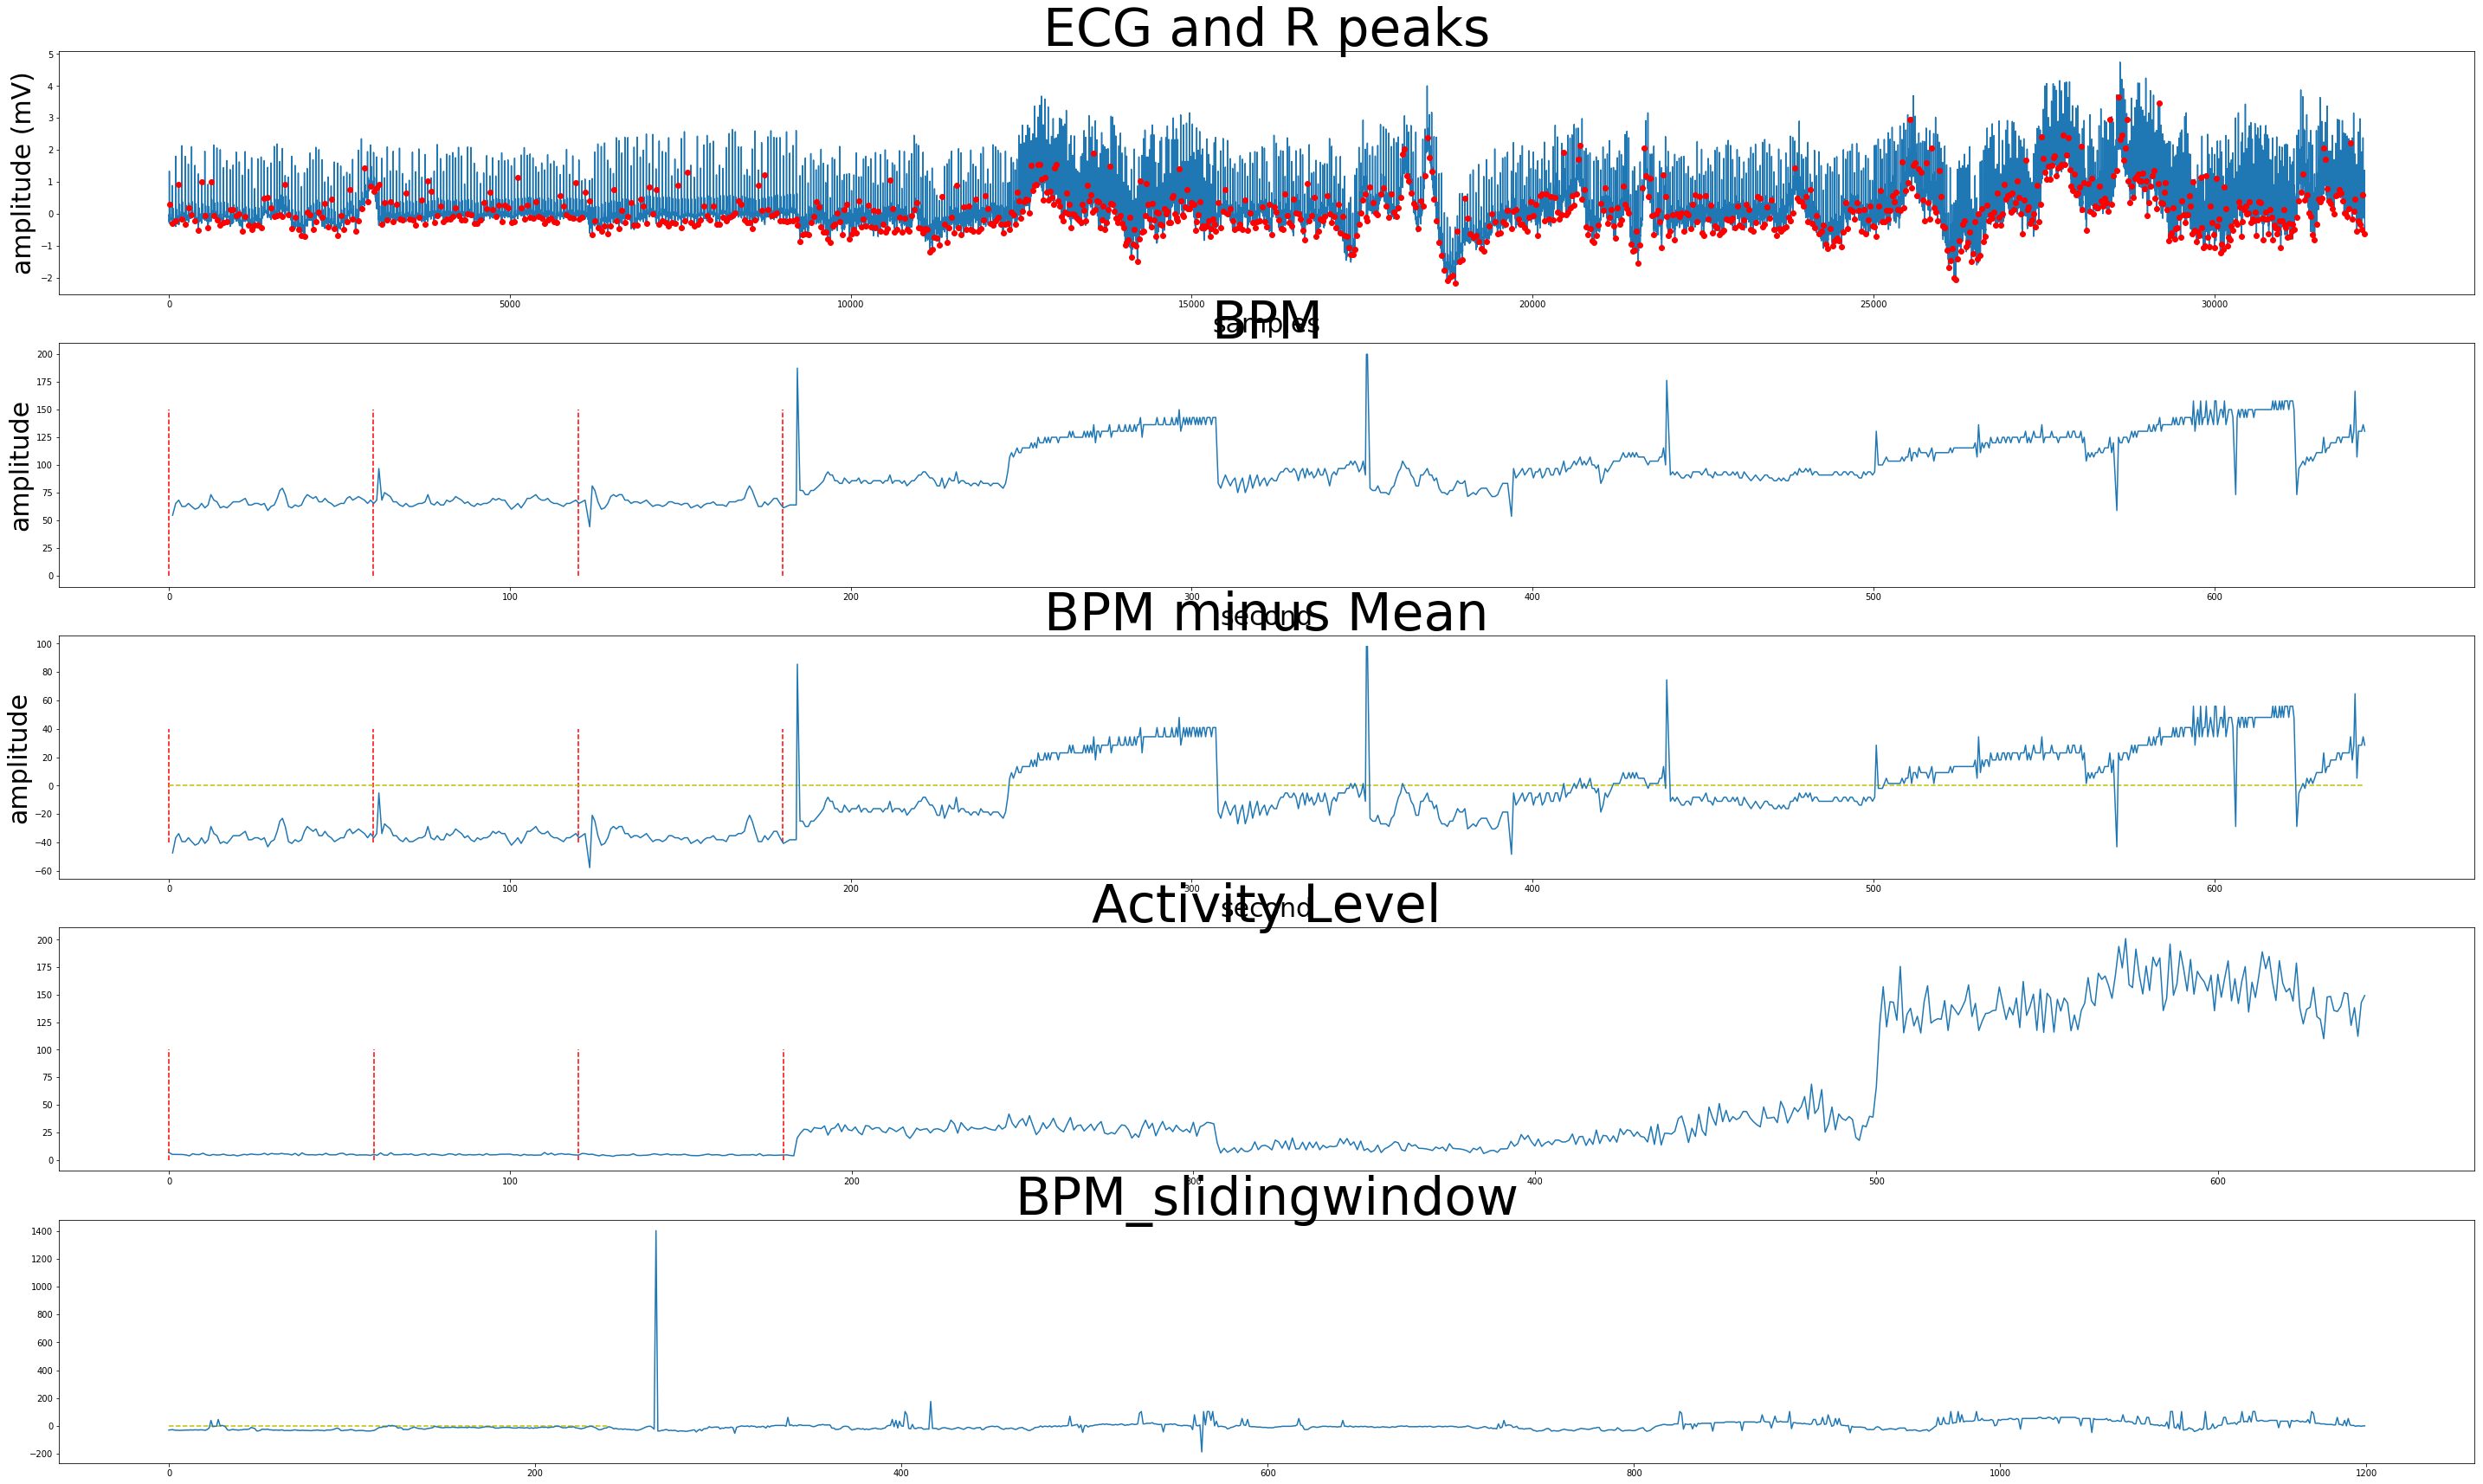

In [484]:
fig = plt.figure(figsize=(50, 30))


subplot1 = fig.add_subplot(511)
subplot2 = fig.add_subplot(512)
subplot3 = fig.add_subplot(513)
subplot4 = fig.add_subplot(514)
subplot5 = fig.add_subplot(515)

subplot1.plot(ecg_measurements)
subplot1.plot(qrs_peaks_indices, ecg_measurements[qrs_peaks_indices], 'ro' )
subplot1.set_title('ECG and R peaks', fontsize = 60)
subplot1.set_xlabel('samples', fontsize = 30)
subplot1.set_ylabel('amplitude (mV)', fontsize = 30)

subplot2.plot(time*0.02, BPM)
subplot2.set_title('BPM', fontsize = 60)
subplot2.set_xlabel('second', fontsize = 30)
subplot2.set_ylabel('amplitude', fontsize = 30)
e = (end-start)/3000
for i in range(0,e,1):
    subplot2.vlines(i*60, 0, 150, colors = "r", linestyles = "dashed")

print "# BPM: ", BPM.shape
print ("mean value: ", BPM.mean())
print ("largest value: ", BPM.max())

BPM_avg = BPM.mean()
subplot3.plot(time*0.02, BPM-BPM_avg)
subplot3.set_title('BPM minus Mean', fontsize = 60)
subplot3.set_xlabel('second', fontsize = 30)
subplot3.set_ylabel('amplitude', fontsize = 30)
for i in range(0,e,1):
    subplot3.vlines(i*60, -40, 40, colors = "r", linestyles = "dashed")
subplot3.hlines(0, 0, (len(new_index))/50, colors = "y", linestyles = "dashed")

#act = az[start:end].values
#print act.shape
#print az[0::50].shape
subplot4.plot(act_level)
print ("Activity Level:", act_level.shape)
subplot4.set_title('Activity Level', fontsize = 60)
for i in range(0,e,1):
    subplot4.vlines(i*60, 0, 100, colors = "r", linestyles = "dashed")
    
subplot5.plot(BPM_slidingwindow-np.mean(BPM_slidingwindow))
subplot5.set_title('BPM_slidingwindow', fontsize = 60)
subplot5.hlines(0, 0, (end-start)/50, colors = "y", linestyles = "dashed")



In [491]:
def slidingwinecg2bpm(ecg):
    et = ecg
    listBPM = np.array([]);
    i = 0
    
    while i < et.shape[0] - 50:
        eb = et[50 * i : 50 * (i + 2)]
        detected_peaks_indices, detected_peaks_values = detect_peaks(eb)
        qrs_peaks_indices, noise_peaks_indices = detect_qrs(eb, detected_peaks_indices, detected_peaks_values)
        time, BPM = ecg2bpm(qrs_peaks_indices)
        bpm = BPM.mean()
        listBPM = np.append(listBPM, bpm)
    return listBPM

In [666]:
def slidingwindecg2bpm(ecg):
    #et = ecg.values
    ecg = ecg.values
    listBPM = np.array([]);
    k = 0
    while k <= len(ecg) - 2999:
        et = ecg[k : k + 2999]
        for i in range(59):
            eb = et[50 * i : 50 * (i + 2) - 1]
            detected_peaks_indices, detected_peaks_values = detect_peaks(eb)
            qrs_peaks_indices, noise_peaks_indices = detect_qrs(eb, detected_peaks_indices, detected_peaks_values)
            time, BPM = ecg2bpm(qrs_peaks_indices)
            bpm =np.median(BPM)
            listBPM = np.append(listBPM, bpm)
            print BPM
        listBPM = np.append(listBPM, listBPM[-1])
            
        k = k + 3000
  
    return listBPM

In [667]:
(ecg_measurements).shape[0]

32205

In [668]:
ecgtest = ECG1[new_index]
print type(ecgtest.values)
wind_bpm = slidingwindecg2bpm(ecgtest)
print wind_bpm.shape
detected_peaks_indices, detected_peaks_values = detect_peaks(ecgtest)
qrs_peaks_indices, noise_peaks_indices = detect_qrs(ecgtest, detected_peaks_indices, detected_peaks_values)
time, BPM = ecg2bpm(qrs_peaks_indices)
print BPM.shape

<type 'numpy.ndarray'>
[ 54.54545455]
[ 58.82352941  68.18181818]
[ 66.66666667  62.5       ]
[ 69.76744186  62.5       ]
[ 34.48275862]
[ 81.08108108  62.5       ]
[ 35.29411765]
[ 60.          88.23529412]
[ 37.5]
[ 37.97468354]
[ 39.47368421]
[ 44.7761194]
[ 49.18032787]
[ 53.57142857]
[ 54.54545455]
[ 56.60377358]
[ 57.69230769  66.66666667]
[ 61.2244898   66.66666667]
[ 68.18181818  66.66666667]
[ 76.92307692  66.66666667]
[ 38.46153846]
[ 107.14285714   69.76744186]
[ 44.11764706]
[ 46.15384615]
[ 200.  200.]
[ 52.63157895]
[ 55.55555556]
[ 60.]
[ 58.82352941  65.2173913 ]
[ 61.2244898   63.82978723]
[ 65.2173913   69.76744186]
[ 76.92307692  76.92307692]
[ 107.14285714   78.94736842   78.94736842]
[  96.77419355  115.38461538]
[ 54.54545455]
[ 55.55555556  55.55555556]
[ 157.89473684  157.89473684  157.89473684]
[ 61.2244898   63.82978723]
[  65.2173913    65.2173913   107.14285714]
[ 76.92307692  73.17073171]
[ 100.           71.42857143]
[ 46.15384615]
[ 52.63157895]
[ 57.6923

[ 85.71428571  83.33333333]
[ 142.85714286   85.71428571   73.17073171]
[ 62.5         73.17073171]
[ 76.92307692  75.        ]
[ 103.44827586  103.44827586  115.38461538]
[ 150.  150.  150.]
[ 63.82978723  78.94736842]
[ 85.71428571  78.94736842  78.94736842]
[ 130.43478261  130.43478261  115.38461538]
[ 54.54545455  71.42857143]
[ 63.82978723  73.17073171]
[ 78.94736842  78.94736842]
[ 115.38461538   83.33333333   85.71428571]
[ 62.5         83.33333333]
[ 88.23529412  53.57142857]
[ 42.25352113  42.25352113]
[ 142.85714286  200.          157.89473684  157.89473684]
[ 78.94736842  93.75      ]
[ 58.82352941  58.82352941  58.82352941]
[ 200.          157.89473684  157.89473684  157.89473684]
[ 63.82978723  96.77419355]
[ 107.14285714   88.23529412   93.75      ]
[ 68.18181818  93.75      ]
[ 115.38461538   96.77419355   88.23529412]
[ 73.17073171  90.90909091  90.90909091]
[ 125.          125.          125.           96.77419355]
[ 83.33333333  83.33333333  83.33333333]
[ 57.69230769 

(1016,)


('mean window bpm', 93.890622846213205)
('mean bpm', 101.76475344766503)
('Activity Level:', (644,))


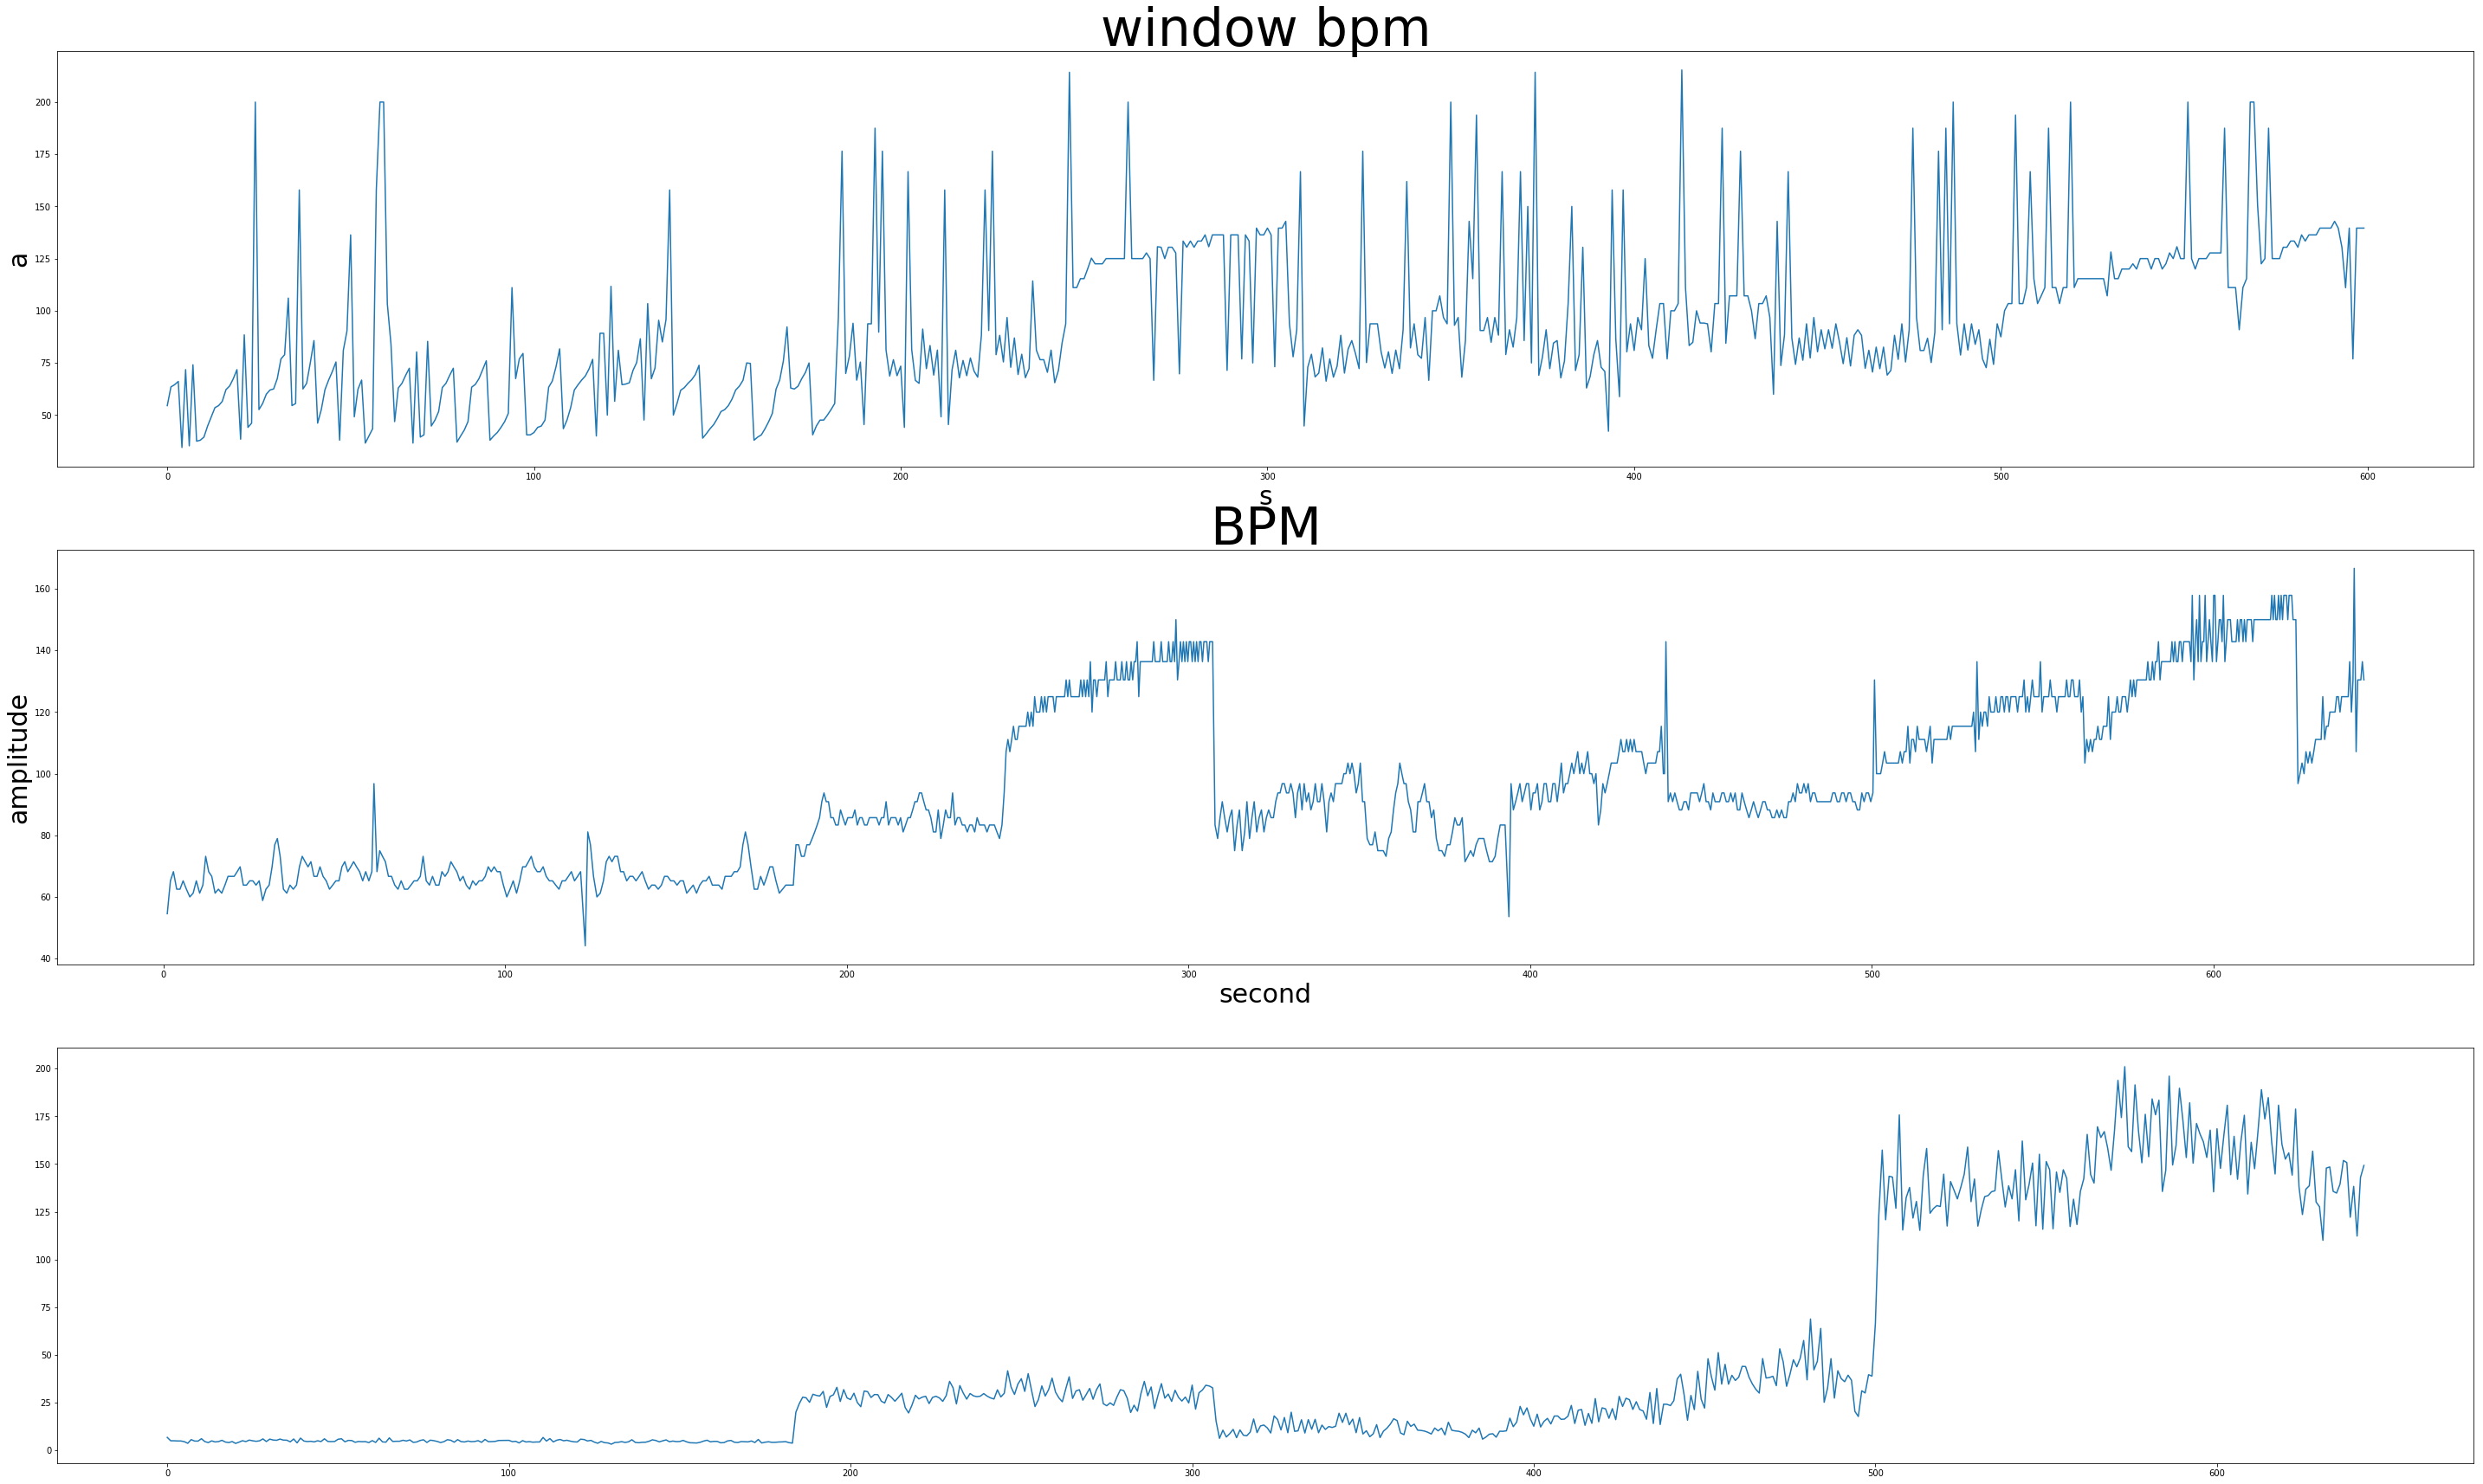

In [669]:
fig = plt.figure(figsize=(50, 30))

subplot1 = fig.add_subplot(311)
subplot2 = fig.add_subplot(312)
subplot3 = fig.add_subplot(313)

subplot1.plot(wind_bpm)
subplot1.set_title('window bpm', fontsize = 60)
subplot1.set_xlabel('s', fontsize = 30)
subplot1.set_ylabel('a', fontsize = 30)

print ("mean window bpm", wind_bpm.mean())
print ("mean bpm", BPM.mean())

subplot2.plot(time*0.02, BPM)
subplot2.set_title('BPM', fontsize = 60)
subplot2.set_xlabel('second', fontsize = 30)
subplot2.set_ylabel('amplitude', fontsize = 30)


acc = a[new_index].values
act_level = activitylevel(acc)
subplot3.plot(act_level)
print ("Activity Level:", act_level.shape)
subplot4.set_title('Activity Level', fontsize = 60)
for i in range(0,e,1):
    subplot4.vlines(i*60, 0, 100, colors = "r", linestyles = "dashed")

# Label i

In [679]:
label_1 = np.where(label == 1) 
index_label1 = label_1[0]
print label_1[0]
ecg_measurements = ECG1[index_label1] # samples for label 1
detected_peaks_indices, detected_peaks_values = detect_peaks(ecg_measurements)
qrs_peaks_indices, noise_peaks_indices = detect_qrs(ecg_measurements, detected_peaks_indices, detected_peaks_values)


time, BPM = ecg2bpm(qrs_peaks_indices)
print len(BPM), len(time)
print time + label_1[0][0] -1 # time contians index for BPM w.r.t the whole dataset

[3072 3073 3074 ..., 6141 6142 6143]
67 67
[ 3126.  3172.  3216.  3264.  3312.  3358.  3406.  3456.  3505.  3551.
  3600.  3647.  3688.  3732.  3777.  3826.  3874.  3923.  3970.  4015.
  4060.  4105.  4149.  4192.  4239.  4286.  4332.  4378.  4425.  4471.
  4522.  4570.  4617.  4660.  4699.  4737.  4778.  4826.  4875.  4922.
  4970.  5017.  5060.  5101.  5143.  5186.  5228.  5273.  5318.  5361.
  5406.  5452.  5500.  5547.  5593.  5639.  5682.  5724.  5768.  5811.
  5853.  5896.  5940.  5986.  6030.  6076.  6120.]


In [700]:
acc = a[index_label1].values
act_level, time = activitylevel(acc)
print act_level.shape
print time + index_label1[0]

(61,)
[ 3072.  3122.  3172.  3222.  3272.  3322.  3372.  3422.  3472.  3522.
  3572.  3622.  3672.  3722.  3772.  3822.  3872.  3922.  3972.  4022.
  4072.  4122.  4172.  4222.  4272.  4322.  4372.  4422.  4472.  4522.
  4572.  4622.  4672.  4722.  4772.  4822.  4872.  4922.  4972.  5022.
  5072.  5122.  5172.  5222.  5272.  5322.  5372.  5422.  5472.  5522.
  5572.  5622.  5672.  5722.  5772.  5822.  5872.  5922.  5972.  6022.
  6072.]
